In [59]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import xarray as xr
import xesmf as xe
import cordex as cx

# Population Data

Download link: https://data.isimip.org/search/tree/ISIMIP2b/SecondaryInputData/socioeconomic/pop/histsoc/pop/

Cite as:

Franziska Piontek, Tobias Geiger (2017): ISIMIP2b secondary population input data (v1.0). ISIMIP Repository. https://doi.org/10.48364/ISIMIP.432399

In [8]:
# download data to your personal directory:
local ='/work/ch0636/g300047/cicles/population/'

In [43]:
# The population data needs to be regridded to the AFR-22 domain.
# Target Grid::
dm=cx.cordex_domain('AFR-22', bounds=True)
# open population file which should be regridded to the AFR-22 domain (conservative)
pop = xr.open_dataset(local+'org/population_ssp5soc_2.5min_annual_1861-2100.nc4',decode_times=False)
# reindex lat (-90 to 90) and reduce to region of interest
pop = pop.reindex(lat=pop['lat'][::-1]).sel(lon=slice(dm.lon.min(),dm.lon.max()),lat=slice(dm.lat.min(),dm.lat.max()))
# compute cell areas
src_area = xe.util.cell_area(pop)
tgt_area = xe.util.cell_area(dm)

In [44]:
# make regridder
%time regridder = xe.Regridder(pop, dm, method='conservative')

CPU times: user 1min 47s, sys: 2.49 s, total: 1min 49s
Wall time: 1min 50s


In [45]:
# regrid population data
# Note: the population data is given in people per square kilometer, so we need to multiply
# by the target area to get the total population in each target cell.
# This is done by dividing the population by the source area and then multiplying by the target area
# to ensure conservation of population.
# This is a common practice in regridding to ensure that the total population is conserved.
# Note: this is a conservative regridding, so the total population should remain the same
%time pop_regrid = regridder(pop / src_area) * tgt_area

/work/ch0636/g300047/.conda/envs/afrheat/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


CPU times: user 13.7 s, sys: 1min, total: 1min 14s
Wall time: 1min 15s


In [46]:
#save pop_regrid to netcdf file
pop_regrid.to_netcdf(
	local+'/org/population_ssp5soc_2.5min_annual_1861-2100_africa22.nc4',
	format='NETCDF4'
)

# Check Results:

In [47]:
# Check results:

total_before = pop['number_of_people'].isel(time=0).sum().item()
total_after = pop_regrid['number_of_people'].isel(time=0).sum().item()
total_before / total_after

0.9999998393554871

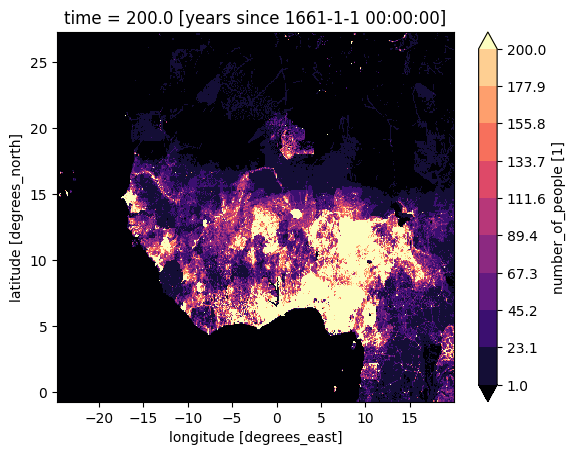

In [58]:
# Horizontal plot of original data
import numpy as np
vmin = 1.0
vmax = 200.0
steps = 10
levels = np.linspace(vmin, vmax, steps)
 #west Afrika
            #lon : -25.87 to 20 by 0.11 degrees
            #lat : -0.75 to 27.3 by 0.11 degrees
pop_small = pop.sel(lon=slice(-25, 20), lat=slice(-0.75, 27.3))
pop_small['number_of_people'].isel(time=0).plot(cmap="magma", vmin=vmin, vmax=vmax, levels=levels)

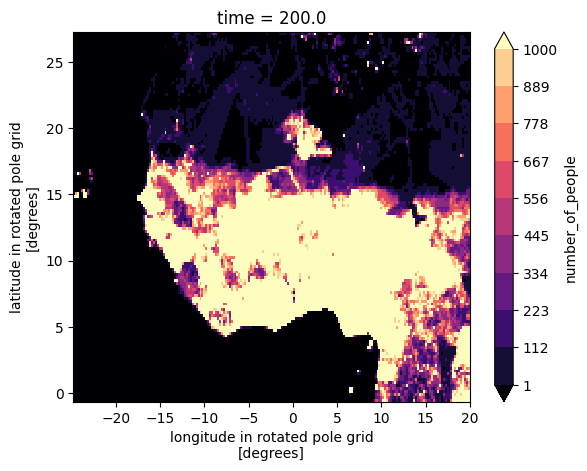

In [49]:
# Horizontal plot of regridded data
import numpy as np
vmin = 1.0
vmax = 1000.0
steps = 10
levels = np.linspace(vmin, vmax, steps)
pop_regrid_small = pop_regrid.sel(rlon=slice(-25, 20), rlat=slice(-0.75, 27.3))
pop_regrid_small['number_of_people'].isel(time=0).plot(cmap="magma", vmin=vmin, vmax=vmax, levels=levels)#1.e5,norm=mcolors.LogNorm())

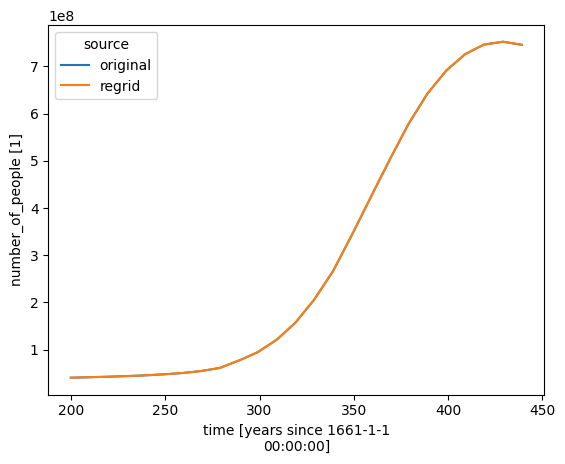

In [50]:
# Here we are essentially plotting the population development; both datasets align exactly, so it seems to be correct.
pop_sum = pop_small['number_of_people'].sum(('lon', 'lat'))
pop_regrid_sum = pop_regrid_small['number_of_people'].sum(('rlon', 'rlat'))
xr.concat([pop_sum, pop_regrid_sum], dim=xr.DataArray(['original', 'regrid'], dims="source")).plot(hue='source')

# Compare population development of ssp1 and ssp3

Text(0.5, 1.0, '1861-2100')

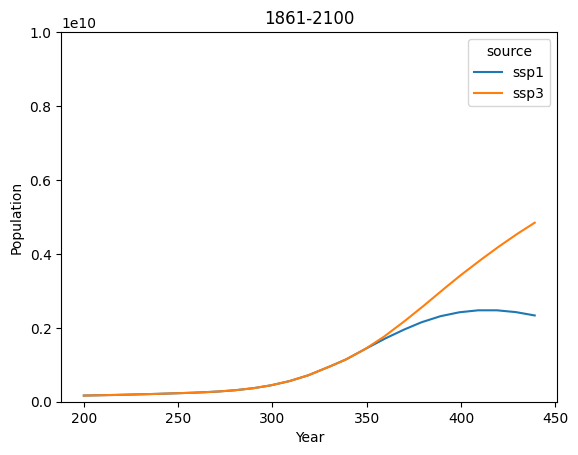

In [53]:
# Here we are essentially plotting the population development; both datasets align exactly, so it seems to be correct.

pop1 = xr.open_dataset(local+'/org/population_ssp1soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=False)
pop3 = xr.open_dataset(local+'/org/population_ssp3soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=False)
pop_regrid_sum1 = pop1['number_of_people'].sum(('rlon', 'rlat'))
pop_regrid_sum3 = pop3['number_of_people'].sum(('rlon', 'rlat'))
import matplotlib.pyplot as plt

ax = xr.concat([pop_regrid_sum1, pop_regrid_sum3], dim=xr.DataArray(['ssp1', 'ssp3'], dims="source")).plot(hue='source')
plt.gca().set_xlabel('Year')

plt.gca().set_ylabel('Population')
plt.gca().set_ylim(0, 10000000000)
plt.gca().set_title('1861-2100')

In [57]:

from format_data_tools import decode_time_pop
pop_dir = '/work/ch0636/g300047/cicles/population/org/'
# The population data got remapped to arf22 grid in a separate script
pop_ssp1 = xr.open_dataset(pop_dir+'/population_ssp1soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=False)
pop_ssp3 = xr.open_dataset(pop_dir+'/population_ssp3soc_2.5min_annual_1861-2100_africa22.nc4',decode_times=False)
#time axis needs to be defined for the population data
pop_ssp1 = decode_time_pop(pop_ssp1)
pop_ssp3 = decode_time_pop(pop_ssp3)
pop_ssp1.time

<xarray.DataArray 'time' (time: 240)> Size: 2kB
array([cftime.DatetimeProlepticGregorian(1861, 1, 3, 11, 46, 56, 129032, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1862, 1, 3, 17, 46, 56, 129032, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1863, 1, 3, 23, 46, 56, 129032, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2098, 1, 4, 17, 46, 56, 129033, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2099, 1, 4, 23, 46, 56, 129033, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2100, 1, 5, 5, 46, 56, 129033, has_year_zero=True)],
      shape=(240,), dtype=object)
Coordinates:
  * time     (time) object 2kB 1861-01-03 11:46:56.129032 ... 2100-01-05 05:4...

In [55]:
def sel_time_mean(ds, start, end):
    return ds.sel(time=slice(start, end)).mean(dim="time")

In [56]:
#Calculate mean population
# 1991-2024 and  2031-2060
pop_1991_2024_ssp1 = sel_time_mean(pop_ssp1, "1991-01-01", "2024-12-31")
pop_2031_2060_ssp1 = sel_time_mean(pop_ssp1, "2031-01-01", "2060-12-31")
#diff_pop_ssp1 = pop_2031_2060_ssp1 - pop_1991_2024_ssp1
#Calculate mean population
# 1991-2024 and  2031-2060
pop_1991_2024_ssp3 = sel_time_mean(pop_ssp3, "1991-01-01", "2024-12-31")
pop_2031_2060_ssp3 = sel_time_mean(pop_ssp3, "2031-01-01", "2060-12-31")
#diff_pop_ssp3 = pop_2031_2060_ssp3 - pop_1991_2024_ssp3
